# 1. Loading Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scipy.stats as stats
import os
import pickle
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_ind
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# 2. DefiningFunctions

In [2]:
# Merging phenotype and PRS data for a cohort
def merging_pheno_and_prs_per_cohort(df_pheno, df_prs):
    """
    Merges phenotype and PRS data based on the 'IID' column and renames key variables. 
    Filters and retains relevant columns, and removes rows with missing data (NaN).
    
    Args:
        df_pheno (pd.DataFrame): The phenotype data for the cohort.
        df_prs (pd.DataFrame): The PRS data for the cohort.
    
    Returns:
        pd.DataFrame: A dataframe containing merged and cleaned phenotype and PRS data.
    """
    
    # Merge phenotype and PRS data on 'IID' (individual ID)
    df = df_prs.merge(df_pheno, on='IID')

    # Rename 'PRS' column to 'SCORE' and 'ADRD' to 'ADRD_FINAL'
    df = df.rename(columns={'PRS': 'SCORE', 'ADRD': 'ADRD_FINAL'})

    # Select relevant columns for analysis
    df = df[['IID', 'ADRD_FINAL', 'SCORE', 'AGE', 'SEX', 'APOEe4']]

    # Remove rows with missing values (NaN)
    df = df.dropna()

    # Display the shape of the final dataframe (number of rows and columns)
    print(df.shape)

    # Return the cleaned and merged dataframe
    return df

In [3]:
def load_data(cohort, path):
    """
    Loads phenotype and PRS data for a given cohort, preprocesses the data by filtering 
    and standardizing key variables, and merges phenotype and PRS data into a single dataframe.

    Args:
        cohort (str): The name of the cohort (used for identifying files).
        path (str): The path to the directory containing the cohort data files.

    Returns:
        pd.DataFrame: A dataframe with merged and preprocessed phenotype and PRS data.
    """

    # Load phenotype data
    pheno_file_path = f"{path}{cohort}/pheno_data1.txt"
    df_pheno = pd.read_csv(pheno_file_path, sep='\t')
    #print(df_pheno)

    # Load PRS data and filter based on the 'In_Regression' column
    prs_file_path = f"{path}{cohort}/prs_data1.txt"
    df_prs = pd.read_csv(prs_file_path, sep=' ')
    df_prs = df_prs[df_prs['In_Regression'] == 'Yes']  # Keep only relevant rows for regression
    #print(df_prs)

    # Merge phenotype and PRS data into a single dataframe
    df_ready = merging_pheno_and_prs_per_cohort(df_pheno, df_prs)
    #print(df_ready)

    # Standardize AGE and SCORE columns using z-score normalization
    df_ready['AGE'] = zscore(df_ready['AGE'])
    df_ready['SCORE'] = zscore(df_ready['SCORE'])
    print(df_ready)

    # Recode SEX column: 1 -> 0, 2 -> 1
    df_ready['SEX'] = df_ready['SEX'].replace({1: 0, 2: 1})

    # Return the processed dataframe
    return df_ready


In [4]:
# Function to compute mean AUC and standard error using bootstrapping
def bootstrap_auc(y_true, y_pred_prob, n_bootstraps=1000, random_seed=42):
    """
    Computes the mean AUC and its standard error using bootstrapping.
    
    Args:
        y_true (array-like): Ground truth (true binary labels).
        y_pred_prob (array-like): Predicted probabilities for the positive class.
        n_bootstraps (int): Number of bootstrap samples to generate. Default is 1000.
        random_seed (int): Seed for reproducibility. Default is 42.
    
    Returns:
        tuple: mean AUC and standard error of AUC.
    """
    
    # Initialize random state for reproducibility
    rng = np.random.RandomState(random_seed)
    
    # List to store AUC values from each bootstrap sample
    bootstrapped_aucs = []
    
    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Sample indices with replacement to create bootstrap sample
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        
        # Check if the bootstrap sample contains at least one positive and one negative class
        if len(np.unique(y_true[indices])) < 2:
            # Skip this sample if both classes are not represented
            continue
        
        # Compute the false positive rate (FPR) and true positive rate (TPR) for the bootstrap sample
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_prob[indices])
        
        # Compute the AUC for the current bootstrap sample
        score = auc(fpr, tpr)
        
        # Append the AUC score to the list
        bootstrapped_aucs.append(score)
    
    # Convert the list of AUC scores to a numpy array
    bootstrapped_aucs = np.array(bootstrapped_aucs)
    
    # Calculate the mean AUC
    mean_auc = np.mean(bootstrapped_aucs)
    
    # Calculate the standard error of AUC
    std_err_auc = np.std(bootstrapped_aucs)
    
    return mean_auc, std_err_auc

In [5]:
# Function to calculate AUC and its confidence interval
def calculate_auc_ci(y_true, y_probs, n_bootstraps=1000, alpha=0.95):
    """
    Calculates the AUC and its confidence interval using bootstrapping.
    
    Args:
        y_true (array-like): Ground truth (true binary labels).
        y_probs (array-like): Predicted probabilities for the positive class.
        n_bootstraps (int): Number of bootstrap samples to generate. Default is 1000.
        alpha (float): Confidence level for the interval. Default is 0.95 (95% confidence).
    
    Returns:
        tuple: mean AUC, lower bound of the confidence interval, and upper bound of the confidence interval.
    """
    
    # List to store AUC values from bootstrap samples
    bootstrapped_aucs = []
    
    # Initialize random state for reproducibility
    rng = np.random.RandomState(42)
    
    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Sample indices with replacement to create bootstrap sample
        indices = rng.randint(0, len(y_probs), len(y_probs))
        
        # Ensure that the bootstrap sample contains at least one positive and one negative class
        if len(np.unique(y_true[indices])) < 2:
            # Skip this iteration if the sample is not representative
            continue
        
        # Compute the false positive rate (FPR) and true positive rate (TPR) for the bootstrap sample
        fpr, tpr, _ = roc_curve(y_true[indices], y_probs[indices])
        
        # Compute the AUC for the current bootstrap sample
        score = auc(fpr, tpr)
        
        # Append the AUC score to the list
        bootstrapped_aucs.append(score)
    
    # Convert the list of AUC scores to a numpy array and sort the values
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()

    # Calculate the confidence interval
    lower_bound = np.percentile(sorted_scores, ((1.0 - alpha) / 2.0) * 100)  # Lower percentile for CI
    upper_bound = np.percentile(sorted_scores, (alpha + ((1.0 - alpha) / 2.0)) * 100)  # Upper percentile for CI
    
    # Return the mean AUC, lower bound, and upper bound of the confidence interval
    return np.mean(bootstrapped_aucs), lower_bound, upper_bound

In [6]:
# Function to train a neural network and plot the ROC curve
def train_and_plot_roc_using_neural_network(df, cohort, base, features):
    """
    Trains a neural network using SMOTE for oversampling, performs hyperparameter tuning with GridSearchCV, 
    and plots the ROC curve for each feature set.

    Args:
        df (pd.DataFrame): The input dataframe containing the data.
        cohort (str): The name of the cohort.
        base (str): The base feature for comparison.
        features (list of list): A list of feature sets to use in the model.

    Returns:
        tuple: False positive rate (FPR), true positive rate (TPR), best model, list of AUC values, 
        mean AUC values, AUC confidence intervals, and AUC sample list.
    """
    
    # Initialize lists to store AUC values and metrics
    list_auc = []
    list_mean_auc = []
    list_std_err_auc = []
    auc_sign_list = []

    # Set up the figure for plotting ROC curves
    plt.figure(figsize=(8, 6))

    # Iterate over the different feature sets
    for feature_set, color in zip(features, ['indianred', 'cornflowerblue', 'mediumseagreen', 'dimgrey']):
        # Select features (X) and the target variable (y)
        X_train = df[feature_set]
        y_train = df['ADRD_FINAL']

        # Apply SMOTE to address class imbalance
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Split the data into training and testing sets (75% train, 25% test)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)
        y_train, y_test = y_train.astype('int'), y_test.astype('int')  # Ensure target is in integer format

        print("Training data shape:", X_train.shape)
        print("Testing data shape:", X_test.shape)

        # Initialize the MLPClassifier (Neural Network) and define the hyperparameter grid
        temp_model = MLPClassifier(random_state=42, max_iter=500)
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Varying hidden layer configurations
            'activation': ['tanh', 'relu'],  # Activation functions
            'solver': ['adam', 'sgd'],  # Optimizers
            'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
            'learning_rate': ['constant', 'adaptive']  # Learning rate schedule
        }

        # Perform hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(estimator=temp_model, param_grid=param_grid, cv=10)
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        model = grid_search.best_estimator_

        # Get predicted probabilities for the test set
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        list_auc.append(roc_auc)

        # Reset indices for y_test and y_prob to avoid mismatches
        y_test = y_test.reset_index(drop=True)
        y_prob = pd.Series(y_prob).reset_index(drop=True)

        # Calculate mean AUC and confidence intervals using bootstrapping
        mean_auc, std_err_auc = bootstrap_auc(y_test, y_prob)  # Mean AUC and standard error
        mean_auc, lower_ci, upper_ci = calculate_auc_ci(y_test, y_prob)  # Mean AUC and CI
        std_err_auc = [lower_ci, upper_ci]

        # Append the calculated mean AUC and confidence interval to the lists
        list_mean_auc.append(mean_auc)
        list_std_err_auc.append(std_err_auc)

        # Calculate confusion matrix metrics: sensitivity and specificity
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Plot the ROC curve with AUC, sensitivity, and specificity
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Diagnosis ~ {feature_set} :\n AUC = {roc_auc:.2f},\n Sensitivity = {sensitivity:.2f},\n Specificity = {specificity:.2f}')

        # Track sample size and AUC value for further analysis
        n_sample = len(y_prob)
        print("AUC:", roc_auc, "Sample size:", n_sample)
        auc_sign_list.append([n_sample, roc_auc])

    # Plot a diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=20)
    plt.ylabel('True Positive Rate (TPR)', fontsize=20)
    plt.title(f'{base} as base, and {cohort} as target', fontsize=15)
    plt.legend(loc="lower right")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)

    # Display the plot
    plt.show()

    # Return relevant metrics and models
    return fpr, tpr, model, list_auc, list_mean_auc, list_std_err_auc, auc_sign_list



# 3. Callling pipeline

(400, 6)
            IID  ADRD_FINAL     SCORE       AGE  SEX  APOEe4
0    6100022501         0.0  1.127052  1.487621  2.0     0.0
1    2501000501         1.0  2.337579 -0.496287  2.0     0.0
2    6100052901         1.0 -1.202366  1.983597  2.0     0.0
3    5500000201         0.0  1.351536 -0.992264  2.0     0.0
4    6100036101         0.0 -0.097232 -0.744275  1.0     0.0
..          ...         ...       ...       ...  ...     ...
395         867         0.0 -1.421055  0.619661  1.0     0.0
396         262         0.0 -0.066769 -0.620281  2.0     0.0
397         943         0.0 -1.452110 -1.612235  2.0     0.0
398         189         0.0 -0.115307 -0.620281  2.0     0.0
399         938         1.0  0.660384  1.611615  1.0     0.0

[400 rows x 6 columns]
Training data shape: (519, 1)
Testing data shape: (173, 1)
AUC: 0.7333154650227821 Sample size: 173


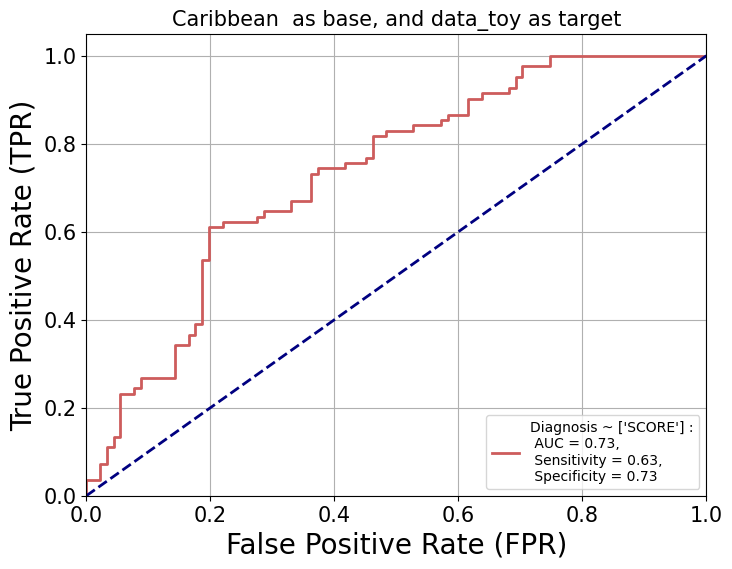

In [7]:
# Global variables
list_cohorts = ['data_toy']  # List of cohort datasets to be processed
path = "../data/"  # Path to the folder containing the cohort data files
base = "Caribbean "  # Base cohort name for labeling the plot

# Iterate through the list of cohorts
for cohort in list_cohorts:
    # Load the data for the current cohort
    df_ready = load_data(cohort, path)

    # Initialize lists to store results for each cohort
    list_auc_all_cohorts_rf = []  # List to store AUC values for the cohort
    all_cohort_list_mean_auc_rf = []  # List to store mean AUC values for the cohort
    all_cohort_list_std_auc_rf = []  # List to store AUC confidence intervals for the cohort
    all_auc_sign_list_rf = []  # List to store AUC sample sizes and AUC values for further analysis

    # Train a logistic regression model, plot the ROC curve, and collect metrics
    fpr, tpr, model, list_auc, list_mean_auc, list_std_err_auc, auc_sign_list = train_and_plot_roc_using_neural_network(
        df_ready, cohort, base, [['SCORE']]
    )

    # Append the results for this cohort to the initialized lists
    list_auc_all_cohorts_rf.append(list_auc)  # Append the AUC values
    all_cohort_list_mean_auc_rf.append(list_mean_auc)  # Append the mean AUC values
    all_cohort_list_std_auc_rf.append(list_std_err_auc)  # Append the standard error/confidence interval of AUC
    all_auc_sign_list_rf.append(auc_sign_list)  # Append sample size and AUC values

    # Format the output by creating DataFrames for easier analysis
    # Create a DataFrame to store the mean AUC for all cohorts
    df_mean = pd.DataFrame(all_cohort_list_mean_auc_rf, columns=['mean'])

    # Create a DataFrame for the confidence intervals by flattening the list and selecting CI values
    df_ci = pd.DataFrame([item[0] for item in all_cohort_list_std_auc_rf], columns=['lower_ci', 'upper_ci'])

    # Concatenate the mean AUC and confidence interval DataFrames into a single DataFrame
    df = pd.concat([df_mean, df_ci], axis=1)

    # Now, df contains the mean AUC, lower confidence interval, and upper confidence interval for the cohort


